## Recommendation Engines
### 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from scipy.stats import skew, norm, probplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')


### Load the Data into the Userdefined Variable

In [7]:
#Read userid-songid-freq triplets
song_df_1 = pd.read_csv('kaggle_visible_evaluation_triplets.txt',sep='\t',names=['user_id','song_id','freq'])

song_df_2 = pd.read_csv('unique_tracks.txt',sep='<SEP>',names = ['track_id','song_id','artist_name','release'])

song_df_2.drop_duplicates(subset ="song_id",keep = False,inplace = True)

##Merge the two dataframes above to create input dataframe for recommender systems
song_df = pd.merge(song_df_1,song_df_2,how = "left" )

### Music data shows how many times a user listened to a song, as well as the details of the song.

In [8]:
song_df.head()

,user_id,song_id,freq,track_id,artist_name,release
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,TRTNDNE128F1486812,Cartola,Tive Sim
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,TRASTUE128F930D488,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,TRFPLWO128F1486B9E,Miguel Calo,El Cuatrero


### The Length of the Data

In [11]:
print("The Length of the Data is ",len(song_df))

The Length of the Data is  1450933


### First we create subset of the dataset

In [13]:
song_df = song_df.head(10000)

#Merge song title and artist_name columns to make a merged column
song_df['song'] = song_df['release'].map(str) + " - " + song_df['artist_name']

### The Most popular songs in data set 

In [14]:
song_grouped = song_df.groupby(['song']).agg({'freq': 'count'}).reset_index()
grouped_sum = song_grouped['freq'].sum()
song_grouped['percentage']  = song_grouped['freq'].div(grouped_sum)*100
song_grouped.sort_values(['freq', 'song'], ascending = [0,1])

,song,freq,percentage
7195,You're The One - Dwight Yoakam,40,0.410088
6602,Undo - BjÃ¶rk,38,0.389584
5160,Sehr kosmisch - Harmonia,36,0.369079
4882,Revelry - Kings Of Leon,32,0.328071
1490,Dog Days Are Over (Radio Edit) - Florence + Th...,29,0.297314
...,...,...,...
7260,Ã–rÃ¶kkÃ© Tart - Tankcsapda,1,0.010252
7261,Ã„nnu En Dag - Drifters,1,0.010252
7262,Ã‡a Marche - Christophe MaÃ©,1,0.010252
7263,Ã�ngel De Amor - Sergio Contreras,1,0.010252


#### Second we have to count number of unique users in the data set

In [17]:
users = song_df['user_id'].unique()
print("The unique users in the data set is ",len(users))

The unique users in the data set is  753


### Third we have to count number of unique songs in the dataset

In [18]:
songs = song_df['song'].unique()
print("The unique songs present in the data set is ",len(songs))

The unique songs present in the data set is  7266


## Create Class for Popularity based Recommender System model

In [23]:
#Class for Popularity based Recommender System model
class popularity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        #Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
    
        #Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations
    

#Class for Item similarity based Recommender System model
class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items
        
    #Get unique users for a given item (song)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
            
        return item_users
        
    #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
            
        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
        ###############################################
        #Initialize the item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
           
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations

### Song Recommender 
#### Split train test 

In [24]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

                                       user_id             song_id  freq  \
7389  d3c75a5a579f29a3a853b3a4ba76d3a2e5243655  SOQTHZW12A8C1400F8     2   
9275  3071be7411e636fcda6c99277a5b51c45a7c4866  SODQPTQ12AF72A64BC     6   
2995  1fa6a4add6eacc3ce1aec44fc37037db2b09bf82  SOUCBEB12A6310E1F9     3   
5316  c8db3788ca8f60d92abf827ad59f424f05897cfc  SOBWFXM12AB0182808    14   
356   6530c4fc41b9110de5d39fe0355fa103c66385f0  SOSIZFO12A58A79934     2   

                track_id               artist_name  \
7389  TRGVRBA128F428E872  CCCP - Fedeli Alla Linea   
9275  TRGAXFP128F428DE85            The Budos Band   
2995  TRSTLSG128E078370C                Kanye West   
5316  TREYVKJ128F931E1B0             Alexi Murdoch   
356   TRYZCJM12903CE0758                   Vicious   

                                   release  \
7389  Aghia Sophia (2008 Digital Remaster)   
9275                              Scorpion   
2995                           Jesus Walks   
5316                            Or

### WE have create Instance of the popularity_recommender_py() Class (MODEL)

In [25]:
pm = popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

### By using Popularity Model make some predictions

In [26]:
user_id = users[5]
pm.recommend(user_id)

,user_id,song,score,Rank
5944,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,You're The One - Dwight Yoakam,34,1.0
5451,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Undo - BjÃ¶rk,31,2.0
4268,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Sehr kosmisch - Harmonia,30,3.0
1239,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Dog Days Are Over (Radio Edit) - Florence + Th...,24,4.0
4046,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Revelry - Kings Of Leon,23,5.0
1637,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Fireflies - Charttraxx Karaoke,19,6.0
1339,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Drop The World - Lil Wayne / Eminem,18,7.0
2172,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Horn Concerto No. 4 in E flat K495: II. Romanc...,17,8.0
4036,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,ReprÃ©sente - Alliance Ethnik,17,9.0
4260,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Secrets - OneRepublic,16,10.0


### Point 1--->  Use the popularity based model to make predictions for the following user id (Note the difference in recommendations from the first user id).

In [27]:
user_id = users[8]
pm.recommend(user_id)

,user_id,song,score,Rank
5944,0f40e074aab2c5f47b7ddc2277fb0295b5b3a058,You're The One - Dwight Yoakam,34,1.0
5451,0f40e074aab2c5f47b7ddc2277fb0295b5b3a058,Undo - BjÃ¶rk,31,2.0
4268,0f40e074aab2c5f47b7ddc2277fb0295b5b3a058,Sehr kosmisch - Harmonia,30,3.0
1239,0f40e074aab2c5f47b7ddc2277fb0295b5b3a058,Dog Days Are Over (Radio Edit) - Florence + Th...,24,4.0
4046,0f40e074aab2c5f47b7ddc2277fb0295b5b3a058,Revelry - Kings Of Leon,23,5.0
1637,0f40e074aab2c5f47b7ddc2277fb0295b5b3a058,Fireflies - Charttraxx Karaoke,19,6.0
1339,0f40e074aab2c5f47b7ddc2277fb0295b5b3a058,Drop The World - Lil Wayne / Eminem,18,7.0
2172,0f40e074aab2c5f47b7ddc2277fb0295b5b3a058,Horn Concerto No. 4 in E flat K495: II. Romanc...,17,8.0
4036,0f40e074aab2c5f47b7ddc2277fb0295b5b3a058,ReprÃ©sente - Alliance Ethnik,17,9.0
4260,0f40e074aab2c5f47b7ddc2277fb0295b5b3a058,Secrets - OneRepublic,16,10.0


### [Collaborative filtering model] Build a song recommender with personalization

#### We now create an item similarity based collaborative filtering model that allows us to make personalized recommendations to each user.

#### Create an instance of item similarity based recommender class

In [28]:
is_model = item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

#### Use the personalized model to make some song recommendations

In [29]:
#Print the songs for the user in training data
user_id = users[5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62:
------------------------------------------------------------------------------------
Un Simple Histoire - Thievery Corporation
Passacaglia - Secret Garden
The Richest Man In Babylon - Thievery Corporation
Pastorale - Secret Garden
Until The Morning - Thievery Corporation
Kryptonite - 3 Doors Down
Illumination - Secret Garden
Love Letters - Dario Marianelli
In The Waiting Line - Zero 7
Big Yellow Taxi - Counting Crows / Vanessa Carlton
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 10
no. of unique songs in the training set: 6000
Non zero values in cooccurence_matrix :202


,user_id,song,score,rank
0,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Shakedown - Au Pairs,0.033333,1
1,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,S-Bahn-Surfen (2007 Digital Remaster) - Spider...,0.033333,2
2,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Attack Of The Killerbirds - Emilie Simon,0.033333,3
3,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Hate (I Really Don't Like You) - Plain White T's,0.033333,4
4,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Ike's Mood - Isaac Hayes,0.033333,5
5,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Dancing In The Moonlight (It's Caught Me In It...,0.033333,6
6,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Rock Climbing [Byte 1] (2005) - Damu The Fudge...,0.033333,7
7,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,Frantic - The Lovely Feathers,0.033333,8
8,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,La Femme Parallel - Thievery Corporation,0.033333,9
9,91b8fac7dc5e03f6cfaf6e2aa7171f14a8354d62,It Had To Be You (Cd) - Motion City Soundtrack,0.033333,10


### Point2----> Use the personalized model to make recommendations for the following user id. (Note the difference in recommendations from the first user id.)

In [30]:
user_id = users[7]

user_items = is_model.get_user_items(user_id)

print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: c34670d9c1718361feb93068a853cead3c95b76a:
------------------------------------------------------------------------------------
Undo - BjÃ¶rk
Ain't Misbehavin - Sam Cooke
You're The One - Dwight Yoakam
Secrets - OneRepublic
Creep (Explicit) - Radiohead
nan
Quiero Verte Sonreir - Carlos Vives
In The End (Album Version) - Linkin Park
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 8
no. of unique songs in the training set: 6000
Non zero values in cooccurence_matrix :1093


,user_id,song,score,rank
0,c34670d9c1718361feb93068a853cead3c95b76a,Horn Concerto No. 4 in E flat K495: II. Romanc...,0.043123,1
1,c34670d9c1718361feb93068a853cead3c95b76a,Livin' On A Prayer - Bon Jovi,0.042873,2
2,c34670d9c1718361feb93068a853cead3c95b76a,Cuando los Ã¡ngeles lloran - ManÃ¡,0.041667,3
3,c34670d9c1718361feb93068a853cead3c95b76a,Quiereme Siempre - Sonora Carruseles,0.041667,4
4,c34670d9c1718361feb93068a853cead3c95b76a,Dieu M'a Donn? La Foi - Ophelie Winter,0.041667,5
5,c34670d9c1718361feb93068a853cead3c95b76a,Cling And Clatter - Lifehouse,0.041667,6
6,c34670d9c1718361feb93068a853cead3c95b76a,Rebelion - Joe Arroyo,0.041667,7
7,c34670d9c1718361feb93068a853cead3c95b76a,La Valse D'AmÃ©lie (Version Piano) - Yann Tiersen,0.041667,8
8,c34670d9c1718361feb93068a853cead3c95b76a,Le Toi Du Moi - Carla Bruni,0.041667,9
9,c34670d9c1718361feb93068a853cead3c95b76a,LumiÃ¨re - Camille,0.041667,10


### We can also apply the model to find similar songs to any song in the dataset

In [31]:
is_model.get_similar_items(['U Smile - Justin Bieber'])

no. of unique songs in the training set: 6000
Non zero values in cooccurence_matrix :56


,user_id,song,score,rank
0,,Stuck In The Moment - Justin Bieber,0.4,1
1,,EMOTIONS - Mariah Carey,0.2,2
2,,Rang De Basanti - Daler Mehndi;Chitra,0.2,3
3,,Praise You In This Storm (Medium w/o backgroun...,0.2,4
4,,Grace Kelly - MIKA,0.2,5
5,,Try Sleeping With A Broken Heart - Alicia Keys,0.2,6
6,,This Time Around - Hanson,0.2,7
7,,Blues By The Hour - Lil' Son Jackson,0.2,8
8,,Unfold (Eagles Ballroom Live Version) - Jason ...,0.2,9
9,,Piano & I - Alicia Keys,0.2,10


### Point 4 -----> Use the personalized recommender model to get similar songs for the following song.

In [35]:
song = 'Yellow - Coldplay'
is_model.get_similar_items([song])

no. of unique songs in the training set: 6000
Non zero values in cooccurence_matrix :0


,user_id,song,score,rank
0,,Fall Line - Jack Johnson,0.0,1
1,,Please Do Not Let Me Go - Ryan Adams,0.0,2
2,,The Girl You Lost (Sander van Doorn Edit) - Sia,0.0,3
3,,Ella Elle L A - Kate Ryan,0.0,4
4,,I Only Think Of You - The Horrors,0.0,5
5,,Time After Time - Everything But The Girl,0.0,6
6,,Love - Sugarland,0.0,7
7,,Cute Without The E (cut From The Team) (Album ...,0.0,8
8,,On Your Way - The Album Leaf,0.0,9
9,,Nothing Is Promised feat. Yung Joc (Amended Al...,0.0,10


In [34]:
song = 'Ella Elle L A - Kate Ryan'
is_model.get_similar_items([song])

no. of unique songs in the training set: 6000
Non zero values in cooccurence_matrix :11


,user_id,song,score,rank
0,,Ven Damelo - Daddy Yankee,1.000000,1
1,,El Tlatoani del barrio - CafÃ© Tacvba,1.000000,2
2,,BlasÃ© BlasÃ© - SNAP!,1.000000,3
3,,Sacred Flame - Carnal Forge,1.000000,4
4,,Y solo se me ocurre amarte (Unplugged) - Aleja...,1.000000,5
5,,Frente A Frente - Bunbury,1.000000,6
6,,CanciÃ³n Optimista - Chetes,1.000000,7
7,,Ahora - Chetes,1.000000,8
8,,Running Away - Kevin Blechdom,0.500000,9
9,,Unite (2009 Digital Remaster) - Beastie Boys,0.166667,10


### Evaluation Model Class

In [46]:
#Class to calculate precision and recall

import random

class precision_recall_calculator():
    
    def __init__(self, test_data, train_data, pm, is_model):
        self.test_data = test_data
        self.train_data = train_data
        self.user_test_sample = None
        self.model1 = pm
        self.model2 = is_model
        
        self.ism_training_dict = dict()
        self.pm_training_dict = dict()
        self.test_dict = dict()
    
    #Method to return random percentage of values from a list
    def remove_percentage(self, list_a, percentage):
        k = int(len(list_a) * percentage)
        random.seed(0)
        indicies = random.sample(range(len(list_a)), k)
        new_list = [list_a[i] for i in indicies]
    
        return new_list
    
    #Create a test sample of users for use in calculating precision
    #and recall
    def create_user_test_sample(self, percentage):
        #Find users common between training and test set
        users_test_and_training = list(set(self.test_data['user_id'].unique()).intersection(set(self.train_data['user_id'].unique())))
        print("Length of user_test_and_training:%d" % len(users_test_and_training))

        #Take only random user_sample of users for evaluations
        self.users_test_sample = self.remove_percentage(users_test_and_training, percentage)

        print("Length of user sample:%d" % len(self.users_test_sample))
        
    #Method to generate recommendations for users in the user test sample
    def get_test_sample_recommendations(self):
        #For these test_sample users, get top 10 recommendations from training set
        #self.ism_training_dict = {}
        #self.pm_training_dict = {}

        #self.test_dict = {}

        for user_id in self.users_test_sample:
            #Get items for user_id from item similarity model
            print("Getting recommendations for user:%s" % user_id)
            user_sim_items = self.model2.recommend(user_id)
            self.ism_training_dict[user_id] = list(user_sim_items["song"])
    
            #Get items for user_id from popularity model
            user_sim_items = self.model1.recommend(user_id)
            self.pm_training_dict[user_id] = list(user_sim_items["song"])
    
            #Get items for user_id from test_data
            test_data_user = self.test_data[self.test_data['user_id'] == user_id]
            self.test_dict[user_id] = set(test_data_user['song'].unique() )
    
    #Method to calculate the precision and recall measures
    def calculate_precision_recall(self):
        #Create cutoff list for precision and recall calculation
        cutoff_list = list(range(1,11))


        #For each distinct cutoff:
        #    1. For each distinct user, calculate precision and recall.
        #    2. Calculate average precision and recall.

        ism_avg_precision_list = []
        ism_avg_recall_list = []
        pm_avg_precision_list = []
        pm_avg_recall_list = []


        num_users_sample = len(self.users_test_sample)
        for N in cutoff_list:
            ism_sum_precision = 0
            ism_sum_recall = 0
            pm_sum_precision = 0
            pm_sum_recall = 0
            ism_avg_precision = 0
            ism_avg_recall = 0
            pm_avg_precision = 0
            pm_avg_recall = 0

            for user_id in self.users_test_sample:
                ism_hitset = self.test_dict[user_id].intersection(set(self.ism_training_dict[user_id][0:N]))
                pm_hitset = self.test_dict[user_id].intersection(set(self.pm_training_dict[user_id][0:N]))
                testset = self.test_dict[user_id]
        
                pm_sum_precision += float(len(pm_hitset))/float(N)
                pm_sum_recall += float(len(pm_hitset))/float(len(testset))

                ism_sum_precision += float(len(ism_hitset))/float(len(testset))
                ism_sum_recall += float(len(ism_hitset))/float(N)
        
            pm_avg_precision = pm_sum_precision/float(num_users_sample)
            pm_avg_recall = pm_sum_recall/float(num_users_sample)
    
            ism_avg_precision = ism_sum_precision/float(num_users_sample)
            ism_avg_recall = ism_sum_recall/float(num_users_sample)

            ism_avg_precision_list.append(ism_avg_precision)
            ism_avg_recall_list.append(ism_avg_recall)
    
            pm_avg_precision_list.append(pm_avg_precision)
            pm_avg_recall_list.append(pm_avg_recall)
            
        return (pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list)
     

    #A wrapper method to calculate all the evaluation measures
    def calculate_measures(self, percentage):
        #Create a test sample of users
        self.create_user_test_sample(percentage)
        
        #Generate recommendations for the test sample users
        self.get_test_sample_recommendations()
        
        #Calculate precision and recall at different cutoff values
        #for popularity mode (pm) as well as item similarity model (ism)
        
        return self.calculate_precision_recall()
        #return (pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list)  

### Comparison between the models
#### We now formally compare the popularity and the personalized models.

#### We use the precision recall calculator class to calculate the evaluation measures

In [50]:

start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:664
Length of user sample:33
Getting recommendations for user:9de45f3b754cdc54410f1b4529648bdff9c68fca
No. of unique songs for the user: 5
no. of unique songs in the training set: 6000
Non zero values in cooccurence_matrix :48
Getting recommendations for user:8deae551b5f302c280e4d0eeef4422d8d11cb6ac
No. of unique songs for the user: 6
no. of unique songs in the training set: 6000
Non zero values in cooccurence_matrix :71
Getting recommendations for user:1d2b805f2d6db169d7599ea537ebb1e850e02578
No. of unique songs for the user: 20
no. of unique songs in the training set: 6000
Non zero values in cooccurence_matrix :526
Getting recommendations for user:a4b065ead61b2d98cbec7e738a9d76b390a6220a
No. of unique songs for the user: 3
no. of unique songs in the training set: 6000
Non zero values in cooccurence_matrix :9
Getting recommendations for user:5f0fc2a714935ff8f320a8a60081672091b98b15
No. of unique songs for the user: 3
no. of unique songs in the training

### plot precision recall curve

In [53]:
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()

Plotting precision recall curves.


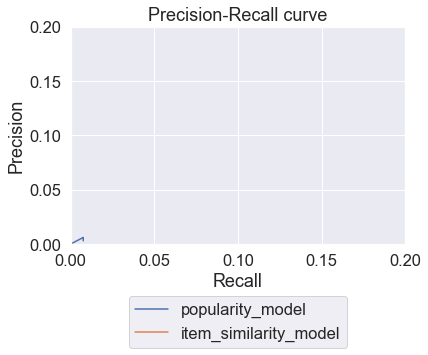

In [54]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

## SVD (Singular Value Decomposition) Based REcommender System 

### Using SVD matrix factorization based collaborative filtering recommender system

#### The following code implements a Singular Value Decomposition (SVD) based matrix factorization collaborative filtering recommender system. The user ratings matrix used is a small matrix as follows: Item0 Item1 Item2 Item3 User0 3 1 2 3 User1 4 3 4 3 User2 3 2 1 5 User3 1 6 5 2 User4 0 0 5 0 As we can see in the above matrix, all users except user 4 rate all items. The code calculates predicted recommendations for user 4.

#### Import Required Libraries 

In [55]:
import math as mt
import csv
from sparsesvd import sparsesvd #used for matrix factorization
import numpy as np
from scipy.sparse import csc_matrix #used for sparse matrix
from scipy.sparse.linalg import * #used for matrix multiplication

ModuleNotFoundError: No module named 'sparsesvd'

#### Methods to compute SVD and recommendations

#### Use SVD to make predictions for a test user id

#### Understanding Intuition behind SVD

#### SVD result gives three matrices as output: U, S and Vt (T in Vt means transpose). Matrix U represents user vectors and Matrix Vt represents item vectors. In simple terms, U represents users as 2 dimensional points in the latent vector space, and Vt represents items as 2 dimensional points in the same space. Next, we print the matrices U, S and Vt and try to interpret them. Think how the points for users and items will look like in a 2 dimensional axis. For example, the following code plots all user vectors from the matrix U in the 2 dimensional space. Similarly, we plot all the item vectors in the same plot from the matrix Vt.